<a href="https://colab.research.google.com/github/Shumin326/MNIST-Image-Classification/blob/master/code/ESE545_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
proj_root = '/content/gdrive/My Drive/ESE 545/proj2'
data_root = '/content/gdrive/My Drive/ESE 545/proj2/data'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
import torchvision
from torchvision import datasets, transforms
import math
import timeit
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

## Problem 1
- data preprocess
- data visualization

In [0]:
X_train_full = np.load(data_root+'/train.npy')
y_train_full = np.load(data_root+'/train_labels.npy')
X_test_full = np.load(data_root+'/test.npy')
y_test_full = np.load(data_root+'/test_labels.npy')

In [0]:
def dataprocess_bi(X,y,X_t, y_t):
    X_train = X.copy()
    y_train = y.copy()
    X_test = X_t.copy()
    y_test = y_t.copy()
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5]))
    X_train = (X_train-127.5)
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5]))
    y_train[y_train==2] = 1
    y_train[y_train==5] = -1
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5]))
    X_test = (X_test-127.5)
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5]))
    y_test[y_test==2] = 1
    y_test[y_test==5] = -1
    X_train = X_train.reshape(len(X_train),28*28)
    X_test = X_test.reshape(len(X_test),28*28)
    return X_train, y_train, X_test, y_test

In [0]:
def dataprocess_tri(X,y,X_t, y_t):
    X_train = X.copy()
    y_train = y.copy()
    X_test = X_t.copy()
    y_test = y_t.copy()
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5],X_train[y_train==7]))
    X_train = (X_train-127.5)
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5],y_train[y_train==7]))
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5],X_test[y_test==7]))
    X_train = (X_train-127.5)
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5],y_test[y_test==7]))
    X_train = X_train.reshape(len(X_train),28*28)
    X_test = X_test.reshape(len(X_test),28*28)
    return X_train, y_train, X_test, y_test

In [0]:
def visualization(X,y):
    X_plt = X.copy()
    y_plt = y.copy()
    X_plt = np.vstack((X_plt[y_plt==2],X_plt[y_plt==5],X_plt[y_plt==7]))
    p = np.random.randint(0,len(y_plt),10)
    X_rand, y_rand = X[p], y_plt[p]
    fig,ax =  plt.subplots(2,5,figsize = (8,8))
    for i in range(10):
        row = int(i/5)
        col = i-5*row
        ax[row][col].imshow(X_rand[i],cmap='gray', vmin=0, vmax=255)
        ax[row][col].set_title('class= '+str(y_rand[i]))
    plt.show()

[[-1.00784314 -1.00784314 -1.00784314 ... -1.00784314 -1.00784314
  -1.00784314]
 [-1.00784314 -1.00784314 -1.00784314 ... -1.0035371  -1.00784314
  -1.00784314]
 [-1.00784314 -1.00784314 -1.00784314 ... -1.00784314 -1.00784314
  -1.00784314]
 ...
 [-1.00784314 -1.00784314 -1.00784314 ... -1.00784314 -1.00784314
  -1.00784314]
 [-1.00784314 -1.00784314 -1.00784314 ... -1.00784314 -1.00784314
  -1.00784314]
 [-1.00784314 -1.00784314 -1.00784314 ... -1.00784314 -1.00784314
  -1.00784314]]


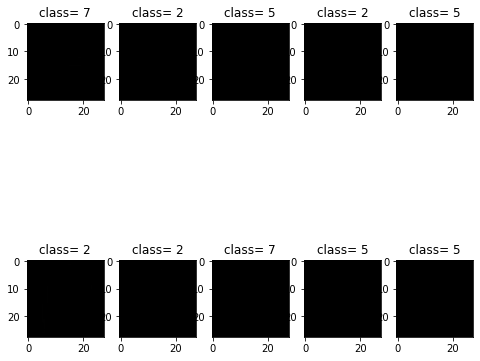

In [88]:
visualization(X_train_full,y_train_full)

#Problem 2
- PEGASOS

In [0]:
def pegasos(X_train,y_train, B=30,lambda_=2,Iter=50):
    # lambda_: lambda_strongly_convex
    # B: batch size
    w = np.zeros(X_train.shape[1])  # initialize w
    W = np.zeros((Iter,X_train.shape[1]))
    for iteration in range(Iter):
        idx = np.random.randint(0,len(X_train),B)
        A_x = X_train[idx]
        A_y = y_train[idx]
        idx_sub = [i for i in range(B) if A_y[i]*w@A_x[i]<1]
        A_x_sub = A_x[idx_sub]
        A_y_sub = A_y[idx_sub]
        yita = 1/((iteration+1)*lambda_)
        delta_t = lambda_*w - yita/B*A_y_sub@A_x_sub
        w_ = w - yita*delta_t
        w = min(1,1/math.sqrt(lambda_)/math.sqrt(sum(w_**2)))*w_
        W[iteration] = w
    return W

In [0]:
def evaluation(W,X_train,y_train,X_test,y_test):
    # input:    W: weights for each iteration, (iteration#,784)
    #           X,y
    # output:   err_train, err_test and corresponding plots
    err_train = np.count_nonzero(np.sign(W@X_train.T)!=y_train,axis=1)/len(y_train)
    err_test = np.count_nonzero(np.sign(W@X_test.T)!=y_test,axis=1)/len(y_test)
    # return err_test[-1],err_train[-1]
    print('best test error:',err_test[-1],'best training error:',err_train[-1])
    plots(err_train,err_test)

In [0]:
def plots(err_train=[],err_test=[]):
    if len(err_train)>0:
        plt.plot(np.arange(len(err_train)),err_train)
        plt.xlabel('iteration')
        plt.ylabel('error')
        plt.title("training error vs iteration")
        plt.show()
    if len(err_test)>0:
        plt.plot(np.arange(len(err_test)),err_test)
        plt.xlabel('iteration')
        plt.ylabel('error')
        plt.title('test error vs iteration')

In [143]:
# for problem 2, use two classes: 2&5
X_train, y_train, X_test, y_test = dataprocess_bi(X_train_full,y_train_full,X_test_full,y_test_full)
W = pegasos(X_train,y_train)
evaluation(W,X_train,y_train,X_test,y_test)

(0.0025, 0.005166666666666667)

In [40]:
# # for parameter tuning, run this part:
# test = 0
# train = 0
# start = timeit.default_timer()
# for i in range(20):
#     W = pegasos(X_train,y_train)
#     err_test, err_train = evaluation(W,X_train,y_train,X_test,y_test)
#     test+= err_test
#     train += err_train
# stop = timeit.default_timer()
# print('average final test error:',test/20,'average final train error:',train/20,'average time cost:',(stop-start)/20)

average final test error: 0.004675 average final train error: 0.0066125 average time cost: 0.1312650817500071


# Problem 3
- adagrad
- permutation needed

In [0]:
def permutate_data(X,y):
    idx = np.random.permutation(len(y))
    X_pmt = X.copy()
    y_pmt = y.copy()
    X_pmt = X_pmt[idx]
    y_pmt = y_pmt[idx]
    return X_pmt,y_pmt

In [0]:
def diag_inv(G):
    diag = np.diagonal(G)
    g = np.zeros((len(G),len(G)))
    np.fill_diagonal(g,diag)
    return g

In [0]:
def updateG(G,xt,yt):
    diag = np.sqrt((yt*xt)**2 + np.diagonal(G)**2)
    g = np.zeros((len(G),len(G)))
    np.fill_diagonal(g,diag)
    return g

In [0]:
def adagrad_svm(X_train,y_train,iteration=50,B=20,yita=0.015):
    G = np.eye(X_train.shape[1])*100
    w = np.zeros(X_train.shape[1])
    W = np.zeros((iteration,X_train.shape[1]))
    err_train = []
    err_test = []
    for i in range(iteration):
        idx = np.random.randint(0,len(X_train),B)
        X = X_train[idx]
        y = y_train[idx]
        for t in range(B):
            if y[t]*(w@X[t])<1:
                deltaf = -y[t]*X[t]
            else:
                deltaf = np.zeros(X.shape[1])
            w -= yita*diag_inv(G)@deltaf
            G = updateG(G,X[t],y[t])
        W[i] = w
    return W

In [141]:
X_train, y_train, X_test, y_test = dataprocess_bi(X_train_full,y_train_full,X_test_full,y_test_full)
X_train, y_train = permutate_data(X_train,y_train)
W = adagrad_svm(X_train,y_train)
evaluation(W,X_train, y_train, X_test, y_test)

(0.005, 0.00575)

In [167]:
# # for parameter tuning, run this part:
# test = 0
# train = 0
# start = timeit.default_timer()
# for i in range(20):
#     W = adagrad_svm(X_train,y_train,yita=0.02)
#     err_test, err_train = evaluation(W,X_train,y_train,X_test,y_test)
#     test += err_test
#     train += err_train
# stop = timeit.default_timer()
# print('average final test error:',test/20,'average final train error:',train/20,'average time cost:',(stop-start)/20)

average final test error: 0.013225000000000004 average final train error: 0.016854166666666667 average time cost: 2.0743455931499737


# problem 5
- one vs one
- pegasos based multi-classfier

In [0]:
def split_tri(X_train,y_train):
    X_train_1 = np.vstack((X_train[y_train==2],X_train[y_train==5]))
    y_train_1 = np.hstack((y_train[y_train==2],y_train[y_train==5]))
    X_train_1,y_train_1 = permutate_data(X_train_1,y_train_1)
    y_train_1[y_train_1==2] = 1
    y_train_1[y_train_1==5] = -1
    X_train_2 = np.vstack((X_train[y_train==2],X_train[y_train==7]))
    y_train_2 = np.hstack((y_train[y_train==2],y_train[y_train==7]))
    X_train_2,y_train_2 = permutate_data(X_train_2,y_train_2)
    y_train_2[y_train_2==2] = 1
    y_train_2[y_train_2==7] = -1

    X_train_3 = np.vstack((X_train[y_train==5],X_train[y_train==7]))
    y_train_3 = np.hstack((y_train[y_train==5],y_train[y_train==7]))
    X_train_3,y_train_3 = permutate_data(X_train_3,y_train_3)
    y_train_3[y_train_3==5] = 1
    y_train_3[y_train_3==7] = -1

    return X_train_1,y_train_1,X_train_2,y_train_2,X_train_3,y_train_3

In [0]:
def det_class(predicts_float):
    #input:     predicts, (3,), e.g. [-1,1,-1]
    #output:    one of the classes{2,5,7}
    predicts = np.sign(predicts_float)
    # certain cases
    if predicts[1]==-1 and predicts[2]==-1:
        return 7
    if predicts[0]==-1 and predicts[2]==1:
        return 5
    if predicts[0]==1 and predicts[1]==1:
        return 2
    # uncertain cases
    L = [2,5,7]
    num_2 = predicts_float[0]+predicts_float[1]
    num_5 = -predicts_float[0]+predicts_float[2]
    num_7 = -predicts_float[1]-predicts_float[2]
    return L[np.argmax([num_2,num_5,num_7])]
    

In [0]:
def multiclass(X_train,y_train,X_test,y_test):
    X_train_1,y_train_1,X_train_2,y_train_2,X_train_3,y_train_3 = split_tri(X_train,y_train)
    # 3 classifiers on label 2,5,7
    # use pegasos
    W_1 = pegasos(X_train_1,y_train_1,Iter = 250)
    W_2 = pegasos(X_train_2,y_train_2,Iter = 250)
    W_3 = pegasos(X_train_3,y_train_3,Iter = 250)
    # use adagrad
    # W_1 = adagrad_svm(X_train_1,y_train_1,iteration=100)
    # W_2 = adagrad_svm(X_train_2,y_train_2,iteration=100)
    # W_3 = adagrad_svm(X_train_3,y_train_3,iteration = 100)
    Y_train_pred = np.zeros((len(W_1),len(y_train),3))
    Y_train_pred[:,:,0] = W_1@X_train.T
    Y_train_pred[:,:,1] = W_2@X_train.T
    Y_train_pred[:,:,2] = W_3@X_train.T
    Y_test_pred = np.zeros((len(W_1),len(y_test),3))
    Y_test_pred[:,:,0] = W_1@X_test.T
    Y_test_pred[:,:,1] = W_2@X_test.T
    Y_test_pred[:,:,2] = W_3@X_test.T
    err_train = []
    err_test = []
    for i in range(len(W_1)):
        seq = map(det_class,Y_train_pred[i,:,:])
        result = np.fromiter(seq, dtype=np.int)
        err_train.append(np.count_nonzero(result!=y_train)/len(y_train))
        seq = map(det_class,Y_test_pred[i,:,:])
        result = np.fromiter(seq, dtype=np.int)
        err_test.append(np.count_nonzero(result!=y_test)/len(y_test))
    return err_train,err_test

best test error: 0.046 best training error: 0.04388888888888889 time spent: 19.52347368699884


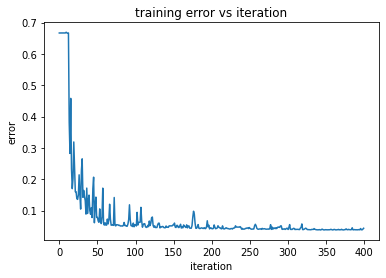

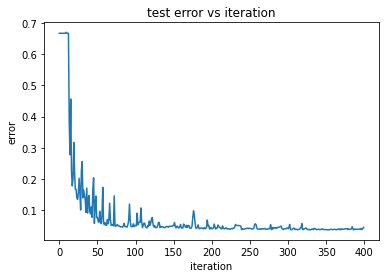

In [65]:
X_train, y_train, X_test, y_test = dataprocess_tri(X_train_full,y_train_full,X_test_full,y_test_full)
start = timeit.default_timer()
err_train,err_test = multiclass(X_train,y_train,X_test,y_test)
stop = timeit.default_timer()
print('final test error:',err_test[-1],'final training error:',err_train[-1],'time spent:',stop-start)
plots(err_train,err_test)

# Problem 6

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,16,5,stride=1, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,32,5,stride=1, padding=2)
        self.drop = nn.Dropout2d(p=0.5)
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):

      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.drop(x)
      x = x.view(-1, 32*7*7)          
      x = self.out(x)
      
      return x

In [0]:
def data_cnn(X,y,X_t,y_t):
    X_train = X.copy()
    y_train = y.copy()
    X_test = X_t.copy()
    y_test = y_t.copy()
    X_train = np.vstack((X_train[y_train==2],X_train[y_train==5],X_train[y_train==7]))
    X_train = (X_train-127.5)/127.5
    X_train = X_train.reshape(len(X_train),1,28,28).astype(np.float32)
    y_train = np.hstack((y_train[y_train==2],y_train[y_train==5],y_train[y_train==7]))
    X_test = np.vstack((X_test[y_test==2],X_test[y_test==5],X_test[y_test==7]))
    X_test = X_test.reshape(len(X_test),1,28,28).astype(np.float32)
    X_test = X_test-127.5/127.5
    y_test = np.hstack((y_test[y_test==2],y_test[y_test==5],y_test[y_test==7]))
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    X_test = torch.from_numpy(X_test)
    y_test = torch.from_numpy(y_test)
    return X_train, y_train, X_test, y_test

In [0]:
def cnn(X_train,y_train,X_test,y_test,B=40,iteration=300):
    err_train = []
    err_test = []

    for epoch in range(iteration):  # loop over the dataset multiple times
        idx = np.random.randint(0,len(X_train),B)
        X = X_train[idx]
        y = y_train[idx]

        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        # get training error for each epoch
        outputs_train = net(X_train)
        _, predicted_train = torch.max(outputs_train.data, 1)
        correct_train = (predicted_train == y_train).sum().item()
        err_train.append(1-correct_train/len(X_train))

        # get test error for each epoch
        outputs_test = net(X_test)
        _, predicted_test = torch.max(outputs_test.data, 1)
        correct_test = (predicted_test == y_test).sum().item()
        err_test.append(1-correct_test/len(X_test))

        if epoch%20==0:
            print('epoch:',epoch,'train error:',1-correct_train/len(y_train),'test error:',1-correct_test/len(y_test))
    print('Finished Training!')
    plots(err_train=err_train,err_test=err_test)

In [0]:
X_train, y_train, X_test, y_test = data_cnn(X_train_full,y_train_full,X_test_full,y_test_full)
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),0.0005)
cnn(X_train,y_train,X_test,y_test)

epoch: 0 train error: 0.6383333333333333 test error: 0.685
